In [1]:
import numpy as np
import pandas as pd
import math
import sklearn.preprocessing
import datetime
from TimeBasedCV import TimeBasedCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
import pickle 
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
# more

In [2]:
# df = pd.read_csv('factors_2002.csv', parse_dates=['DATE'])

In [3]:

# with open('data/features_1965.pkl', 'wb') as f:
#     pickle.dump(df, f)

with open('data/features_1965.pkl', 'rb') as f:
    df = pickle.load(f)
    print(df.head())



   permno       DATE        mvel1      beta    betasq     chmom     dolvol  \
0   10145 1965-02-26   1498872.00  0.983510  0.967291  0.105988  11.546907   
1   10401 1965-02-26  35392058.00  0.780829  0.609694 -0.063768  12.240330   
2   10786 1965-02-26   1695284.75  0.806119  0.649827 -0.130519  12.005040   
3   10989 1965-02-26   1295887.75  1.199748  1.439395  0.073609  11.756961   
4   11260 1965-02-26   2302001.25  1.257269  1.580725 -0.167320  12.240330   

    idiovol    indmom     mom1m  ...  macro_ep  macro_bm  macro_ntis  \
0  0.022307  0.035075  0.104116  ...  2.936836  0.471399    0.014823   
1  0.013395  0.335139 -0.007326  ...  2.936836  0.471399    0.014823   
2  0.024366  0.104106  0.060498  ...  2.936836  0.471399    0.014823   
3  0.022717  0.118513  0.068807  ...  2.936836  0.471399    0.014823   
4  0.035883  0.185424 -0.036885  ...  2.936836  0.471399    0.014823   

   macro_tbl  macro_tms  macro_dfy  macro_svar  macro_mkt-rf  macro_hml  \
0     0.0393    -0.0379

In [ ]:
df[df.columns[2:]] = df[df.columns[2:]].astype('float32')
df = df.sort_values(by = ['DATE', 'permno'], ascending = True)
df.head()


In [ ]:
df['permno2'] = df['permno'].copy()
df['DATE2'] = df['DATE'].copy()
df = df.set_index(['DATE2','permno2'])

df['mvel12'] = df['mvel1'].copy()

In [ ]:
p=0.3 
df_large= df.groupby('DATE').apply(lambda x: x.nlargest(int(len(x)*p),'mvel1')).reset_index(drop=True)  
df_small = df.groupby('DATE').apply(lambda x: x.nsmallest(int(len(x)*p),'mvel1')).reset_index(drop=True)  


In [ ]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium'])].tolist()
df[features]=df.groupby('DATE')[features].rank(pct=True)
df[features] = 2*df[features] - 1

df_large[features]=df_large.groupby('DATE')[features].rank(pct=True)
df_large[features] = 2*df_large[features] - 1

df_small[features]=df_small.groupby('DATE')[features].rank(pct=True)
df_small[features] = 2*df_small[features] - 1

In [ ]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2', 'DATE2', 'risk_premium'])].tolist()

X = df[features]
y = df[['risk_premium']]


predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}

numpc_time = {}

numpc =np.arange(1, 35, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)

for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    

    for i in range(len(numpc)):
        pls_val = PLSRegression(n_components = numpc[i], scale = False)
        pls_val.fit(X_train, y_train)
        Yval_predict=pls_val.predict(X_val)
        Yval_predict = Yval_predict.ravel()
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))
      
    optim_numpc = numpc[np.argmin(mse)]
    
    pls = PLSRegression(n_components=optim_numpc, scale = False)
    pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = pls.predict(X_test)
    preds = preds.ravel()

    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    r2 = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    dic_r2_all["r2." + str(y_test.index)] = r2
    numpc_time["numpc." + str(y_test.index)] = optim_numpc
        
predictions_all= np.concatenate(predictions, axis=0)
y_test_list_all= np.concatenate(y_test_list, axis=0) 
dates_all= np.concatenate(dates, axis=0)

R2OOS_PLS = r2_score(y_test_list_all, predictions_all)
print("R2OOS partial least squares: ", R2OOS_PLS)

In [ ]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2', 'DATE2', 'risk_premium'])].tolist()

X = df_large[features]
y = df_large[['risk_premium']]


predictions_top = []
y_test_list_top =[]
dates_top = []
dic_r2_all_top = {}

numpc =np.arange(1, 35, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    for i in range(len(numpc)):
        pls_val = PLSRegression(n_components = numpc[i], scale = False)
        pls_val.fit(X_train, y_train)
        Yval_predict=pls_val.predict(X_val)
        Yval_predict = Yval_predict.ravel()
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

    optim_numpc = numpc[np.argmin(mse)]
    
    pls = PLSRegression(n_components=optim_numpc, scale = False)
    pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = pls.predict(X_test)

    predictions_top.append(preds)
    dates_top.append(y_test.index)
    y_test_list_top.append(y_test)
    
  
    r2 = 1-np.sum(pow(y_test-preds,2))/np.sum(pow(y_test,2))
    dic_r2_all_top["r2." + str(y_test.index)] = r2


predictions_all_top= np.concatenate(predictions_top, axis=0)
y_test_list_all_top= np.concatenate(y_test_list_top, axis=0) 
dates_all_top= np.concatenate(dates_top, axis=0)

R2TOP = r2_score(y_test_list_all_top, predictions_all_top)
R2TOP

In [ ]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'DATE2', 'risk_premium'])].tolist()

X = df_small[features]
y = df_small[['risk_premium']]

predictions_bottom = []
y_test_list_bottom =[]
dates_bottom = []
dic_r2_all_bottom = {}

numpc =np.arange(1, 35, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    for i in range(len(numpc)):
        pls_val = PLSRegression(n_components = numpc[i], scale = False)
        pls_val.fit(X_train, y_train)
        Yval_predict=pls_val.predict(X_val)
        Yval_predict = Yval_predict.ravel()
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

    optim_numpc = numpc[np.argmin(mse)]
    
    pls = PLSRegression(n_components=optim_numpc, scale = False)
    pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = pls.predict(X_test)
    preds = preds.ravel()

    predictions_bottom.append(preds)
    dates_bottom.append(y_test.index)
    y_test_list_bottom.append(y_test)
    
  
    r2 = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    dic_r2_all_bottom["r2." + str(y_test.index)] = r2


predictions_all_bottom= np.concatenate(predictions_bottom, axis=0)
y_test_list_all_bottom= np.concatenate(y_test_list_bottom, axis=0) 
dates_all_bottom= np.concatenate(dates_bottom, axis=0)

R2BOTTOM = r2_score(y_test_list_all_bottom, predictions_all_bottom)
R2BOTTOM

In [ ]:
chart = np.array([[R2OOS_PLS],
                  [R2TOP],
                  [R2BOTTOM]])

r2_pls = pd.DataFrame(chart, columns=['PLS Regression'],
                     index=['Full Sample', 'Large Firms', 'Small Firms'])

r2_pls

In [ ]:
r2_pls.to_csv(r'r2_PLS_model.csv')

In [4]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'macro_mkt-rf', 'macro_hml', 'macro_smb','risk_premium', 'year'])].tolist()
df['year'] = df['DATE'].dt.year

X_train = df[features].loc[(df["year"]>=2013) & (df["year"]<=2018)]
y_train = df["risk_premium"].loc[(df["year"]>=2013) & (df["year"]<=2018)]

X_val = df[features].loc[(df["year"]>=2019) & (df["year"]<=2020)]
y_val = df["risk_premium"].loc[(df["year"]>=2019) & (df["year"]<=2020)]

numpc =np.arange(1, 35, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)

for i in range(len(numpc)):
    pls_val = PLSRegression(n_components = numpc[i], scale = False)
    pls_val.fit(X_train, y_train)
    Yval_predict=pls_val.predict(X_val)
    Yval_predict = Yval_predict.ravel()
    mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

optim_numpc = numpc[np.argmin(mse)]
pls = PLSRegression(n_components=optim_numpc, scale = False)
pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
preds = pls.predict(np.concatenate((X_train, X_val))) 
preds = preds.ravel()

R2OOS_all = 1-np.sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
print(R2OOS_all)

0.07431785218289766


In [5]:
for j in features:
    globals()['df_' + str(j)] =  df.copy()
    globals()['df_' + str(j)][str(j)] = 0

In [6]:
dic = {}    
numpc =np.arange(1, 35, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)
    
for j in features:
    print(j)
    df_var = globals()['df_' + str(j)]
    
    
    X_train = df_var[features].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]
    y_train = df_var["risk_premium"].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]

    X_val = df_var[features].loc[(df_var["year"]>=2019) & (df_var["year"]<=2020)]
    y_val = df_var["risk_premium"].loc[(df_var["year"]>=2019) & (df_var["year"]<=2020)]


    for i in range(len(numpc)):
        pls_val = PLSRegression(n_components = numpc[i], scale = False)
        pls_val.fit(X_train, y_train)
        Yval_predict=pls_val.predict(X_val)
        Yval_predict = Yval_predict.ravel()
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))
       
    optim_numpc = numpc[np.argmin(mse)]
    pls = PLSRegression(n_components=optim_numpc, scale = False)
    pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = pls.predict(np.concatenate((X_train, X_val))) 
    preds = preds.ravel()
    R2OOS_var = 1-sum(pow(np.concatenate((y_train, y_val))-preds,2))/sum(pow(np.concatenate((y_train, y_val)),2))
    dic['R2OOS_' + str(j)] = R2OOS_var

mvel1
beta
betasq
chmom
dolvol
idiovol
indmom
mom1m
mom6m
mom12m
mom36m
pricedelay
turn
absacc
acc
age
agr
bm
bm_ia
cashdebt
cashpr
cfp
cfp_ia
chatoia
chcsho
chempia
chinv
chpmia
convind
currat
depr
divi
divo
dy
egr
ep
gma
grcapx
grltnoa
herf
hire
invest
lev
lgr
mve_ia
operprof
orgcap
pchcapx_ia
pchcurrat
pchdepr
pchgm_pchsale
pchquick
pchsale_pchinvt
pchsale_pchrect
pchsale_pchxsga
pchsaleinv
pctacc
ps
quick
rd
roic
salecash
saleinv
salerec
securedind
sgr
sin
sp
tang
tb
baspread
ill
maxret
retvol
std_dolvol
std_turn
zerotrade
macro_dp
macro_ep
macro_bm
macro_ntis
macro_tbl
macro_tms
macro_dfy
macro_svar


In [7]:
pd.DataFrame(dic.items())
imp=pd.DataFrame(dic.items(), columns=['Feature', 'R2OOS'])
imp["Feature"] = imp["Feature"].str[6:]

imp["red_R2OOS"] = R2OOS_all -imp["R2OOS"]
imp["var_imp"] = imp["red_R2OOS"]/sum(imp["red_R2OOS"])
imp=imp.sort_values(by = ['var_imp'], ascending = False)
imp

,Feature,R2OOS,red_R2OOS,var_imp
79,macro_bm,0.050977,0.023341,0.302690
77,macro_dp,0.054470,0.019848,0.257389
82,macro_tms,0.062827,0.011491,0.149011
72,maxret,0.068900,0.005417,0.070254
78,macro_ep,0.071954,0.002364,0.030653
...,...,...,...,...
55,pchsaleinv,0.074664,-0.000346,-0.004487
53,pchsale_pchrect,0.074837,-0.000519,-0.006733
49,pchdepr,0.074853,-0.000535,-0.006938
65,sgr,0.075318,-0.001001,-0.012976


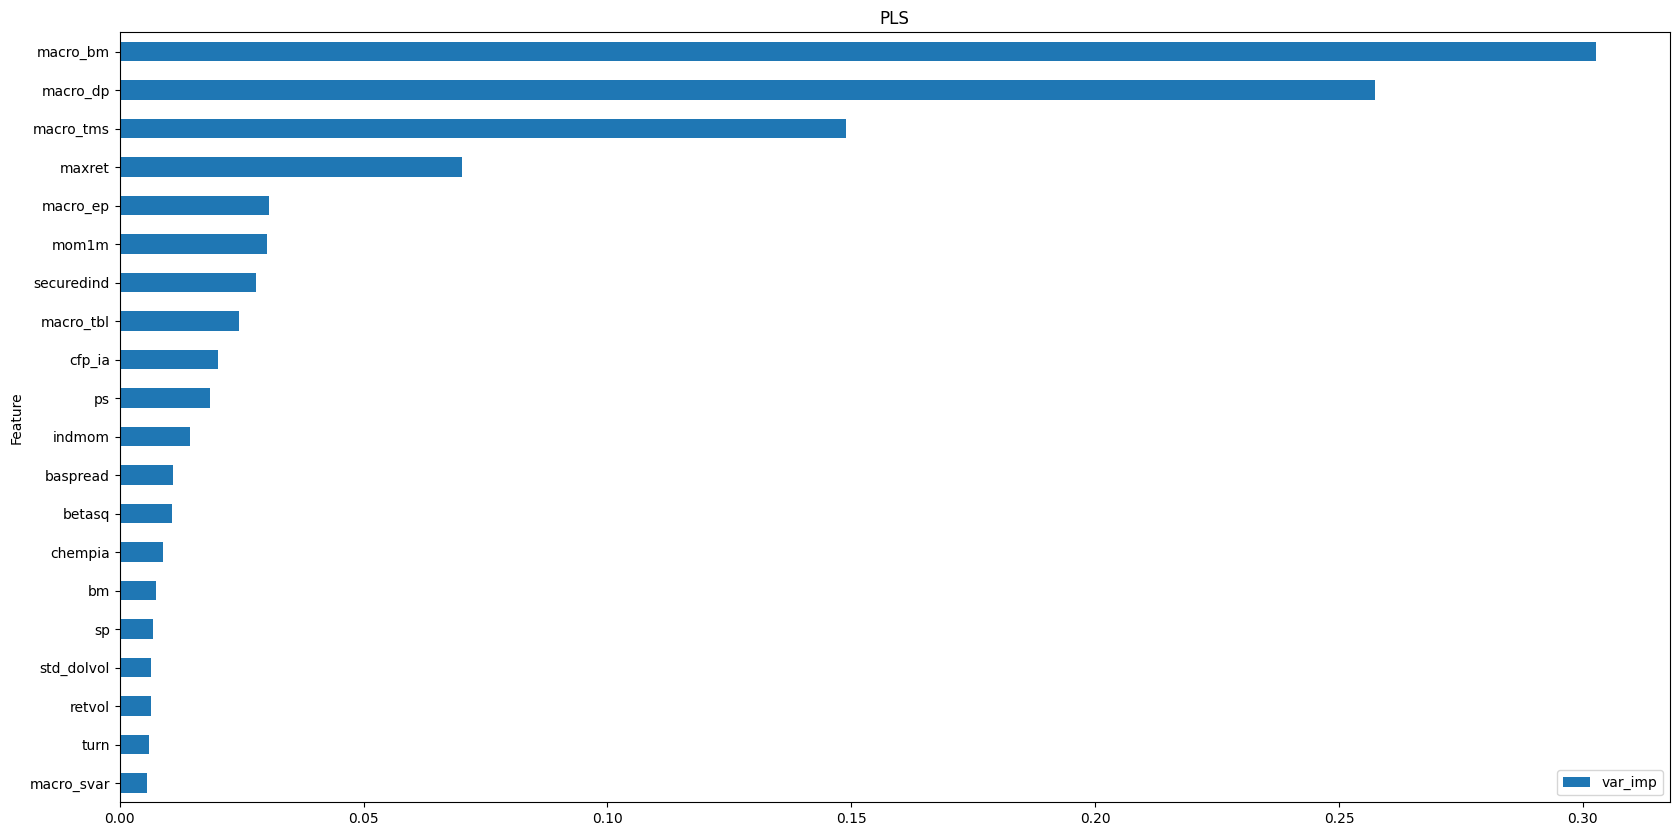

In [8]:
fea_imp_graph = imp.sort_values(['var_imp', 'Feature'], ascending=[True, False]).iloc[-20:]
_ = fea_imp_graph.plot(kind='barh', x='Feature', y='var_imp', figsize=(20, 10))
plt.title('PLS')
plt.show()

In [9]:
var_imp_pls=imp[["Feature", "var_imp"]]
var_imp_pls.to_csv(r'var_imp_pls.csv', index = False)

In [ ]:
yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[35:40]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results.head()

# results['yhat'] = results['yhat'].apply(lambda x: x[0])
results['y_true'] = results['y_true'].apply(lambda x: x[0])

data = df[['mvel12', 'macro_tbl', 'macro_svar']].copy()
data.reset_index(inplace=True)
data['permno2'] = data['permno2'].astype('str')
data['MonthYear'] = data['DATE2'].dt.to_period('M')
data.drop('DATE2', axis=1, inplace=True)
data.rename(columns={'permno2': 'id'}, inplace=True)
data.rename(columns={'mvel12': 'market_cap'}, inplace=True)
data.rename(columns={'macro_tbl': 'risk_free_rate'}, inplace=True)
data = data.set_index(['MonthYear','id'])

bigdata = pd.merge(results, data,left_index=True, right_index=True)
bigdata.reset_index(inplace=True)
bigdata.head()
bigdata['returns'] = bigdata['y_true'] + bigdata['risk_free_rate']

In [ ]:
bigdata["MonthYear1"]= bigdata["MonthYear"].copy()
bigdata["MonthYear"]= bigdata["MonthYear"].astype("int64")
bigdata["NumMonth"]= bigdata["MonthYear"] - 83
bigdata["NumMonth"].unique()

In [ ]:
bigdata.to_csv('predictions/pls.csv', index=False)

In [ ]:
bigdata = pd.read_csv('predictions/pls.csv')

In [ ]:
top_100 = bigdata.sort_values(['NumMonth','yhat'], ascending=[True, True]).groupby(['MonthYear'],
                                                                  as_index=False,
                                                                  sort=False).tail(100)

In [ ]:
portfolio = top_100[['date', 'NumMonth','MonthYear', 'id', 'yhat', 'y_true', 'risk_free_rate', 'MonthYear1']]
portfolio.reset_index(inplace=True)
portfolio.drop(columns=['index'],inplace=True)
portfolio['eq_weights'] = 1/portfolio.groupby('MonthYear')['id'].transform('size')
portfolio['excess_return_stock_ew'] = portfolio['y_true'] *portfolio['eq_weights']
portfolio['pred_excess_return_stock_ew'] = portfolio["yhat"]*portfolio["eq_weights"]

In [ ]:
mean_pred_return = portfolio.groupby('MonthYear')['pred_excess_return_stock_ew'].transform('sum').mean()
mean_port_return = portfolio.groupby('MonthYear')['excess_return_stock_ew'].transform('sum').mean()
port_vol =  portfolio.groupby('MonthYear')["pred_excess_return_stock_ew"].transform('sum').std()
sharp_ratio = (mean_pred_return/port_vol)*np.sqrt(12)

In [ ]:
chart_np = np.array([[mean_port_return, mean_pred_return, port_vol, sharp_ratio]])

ew_df = pd.DataFrame(chart_np, columns=['Real', 'Pred', 'Std', 'Sharpe'],
                                index=['PLS Regression'])

ew_df['Real'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Real']], index= ew_df.index)
ew_df['Pred'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Pred']], index= ew_df.index)
ew_df['Std'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Std']], index= ew_df.index)
ew_df['Sharpe'] = pd.Series(['{0:.2f}%'.format(val) for val in ew_df['Sharpe']], index= ew_df.index)
ew_df


In [ ]:
pd.DataFrame(numpc_time.items())
numpc_table = pd.DataFrame(numpc_time.items(), columns=['Identifier', 'num_comp'])
numpc_table['Identifier'] = numpc_table['Identifier'].astype(str)
numpc_table['time'] = numpc_table['Identifier'].str[20:30]
numpc_table['time'] = pd.to_datetime(numpc_table['time'], utc=False)
numpc_table['time'] = numpc_table['time'].dt.year
numpc_table.drop(['Identifier'], axis = 1, inplace=True)

numpc_table.set_index('time').plot()
numpc_table.to_csv(r'comp_pls.csv')

In [ ]:
numpc_table.to_csv('comp_pls.csv')